This notebook builds Direct Preference Optimization (DPO) from the ground up and applies it to a large language model (LLM) to improve how well its responses reflect user preferences.

## **Loading a Preference Datasaet**

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-with-preference.json"
url = "https://raw.githubusercontent.com/abdussahid26/LLM-Post-training-Techniques/main/instruction-data-with-preference.json"

data = download_and_load_file(file_path, url)
print(f"Number of entries: {len(data)}")

Number of entries: 1100


In [2]:
import pprint

pprint.pp(data[0])

{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}


In [3]:
pprint.pp(data[1])

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


### Dataset Overview

The dataset consists of **5 keys**:

1. **`instruction`** and **`input`**:  
   These are used as inputs to the LLM.

2. **`output`**:  
   This contains the response that the model was trained on during the [`Supervised Instruction Fine-tuning`](https://github.com/abdussahid26/LLM-Post-training-Techniques/blob/main/Supervised_Instruction_Fine_tuning.ipynb) phase.

3. **`chosen`** and **`rejected`**:  
   These are used for **DPO**.  
   - `chosen` is the **preferred** response.  
   - `rejected` is the **dispreferred** response.

---

### Objective

The goal is to fine-tune the model to **prefer the style and content of the `chosen` responses** over the `rejected` ones.


Let's format the model input by applying the **Alpaca** prompt style.

## **Alpaca prompt style template:**
Below is an instruction that describes a task. Write a response that appropriately completes the request.

**\### Instruction:** <br>Identify the correct spelling of the following word.

**\### Input:** <br>Ocassion

**\### Response:** <br>The correct spelling is 'Occasion'.

In [4]:
def format_input(entry):
    instruction_text=(
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text=f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

In [5]:
model_input = format_input(data[0])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


Similarly, we can format the chosen and rejected responses using the **Alpaca prompt style**.

In [6]:
desired_response=f"### Response: \n{data[0]['chosen']}"
print(desired_response)

### Response: 
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [7]:
possible_response=f"### Response:\n{data[0]['rejected']}"
print(possible_response)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


## Creating Training, Validation, & Testsplit

In [8]:
train_portion=int(0.85 * len(data)) # 85% for training
test_portion=int(0.1 * len(data)) # 10% for testing
val_portion=len(data) - train_portion - test_portion # Remaining 5% for validation

train_data = data[: train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion :]

print(f"Training set length: {len(train_data)}")
print(f"Test set length: {len(test_data)}")
print(f"Validation set length: {len(val_data)}")

Training set length: 935
Test set length: 110
Validation set length: 55


### Creating a `PerformanceDataset` Class and Batch Processing Function

In [9]:
import torch
from torch.utils.data import Dataset

class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data=data
        self.encoded_texts=[]
        for entry in data:
            prompt=format_input(entry)
            chosen_response=entry['chosen']
            rejected_response=entry['rejected']

            prompt_tokens=tokenizer.encode(prompt)
            chosen_full_text=f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text=f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens=tokenizer.encode(chosen_full_text)
            rejected_full_tokens=tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })
    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [10]:
%%capture
!pip install tiktoken

In [11]:
import tiktoken

tokenizer=tiktoken.get_encoding("gpt2")
train_dataset=PreferenceDataset(train_data, tokenizer)

print(f"length of tokenize data[20]: {len(train_dataset[20])}") # prompt, chosen, response
print(f"length of tokenize data[21]: {len(train_dataset[21])}")
print(f"length of tokenize data[22]: {len(train_dataset[22])}")
print(f"length of tokenize data[23]: {len(train_dataset[23])}")
print(f"length of tokenize data[24]: {len(train_dataset[24])}")

length of tokenize data[20]: 3
length of tokenize data[21]: 3
length of tokenize data[22]: 3
length of tokenize data[23]: 3
length of tokenize data[24]: 3


We want to accelerate training by collecting multiple training examples in a `batch`, which necessitates padding all inputs to a similar length. Instead of appending the `<|endoftext|>` tokens to the text inputs, we can append the token ID 50256. For padding purpose, we adopt a more sophisticated approach by developing a custom `collate_function` that we can pass to the `dataloader`. This custom collate function pads the training examples in each batch to the same length while allowing different batches to have different lengths. This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole datset.

In [12]:
def collate_function(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to contain batch data
    batch_data={
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []
    }

    # Determine the longest sequence to set a common padding length
    max_length_common=0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key]) + 1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Step 3: Adjust to the common maximum length with padding tokens (end of text token, 50256)
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool() # Create a boolean mask of the same length as padded, initialized to True

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newliine ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False # Our aim is to optimize the response quality, not the prompt interpretation.
                # prompt.shape[0] is the number of tokens in the prompt

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key]) # [Batch_Size, Sequence_Length]

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, : allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

In [13]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

customized_collate = partial(
    collate_function,
    device = device,
    mask_prompt_tokens = True, # Optional
    allowed_max_length = 1024 # The supported context length of the model
)

Device: cuda


Now, let's see the `customized_collate` in action and apply it to some sample data from our preference dataset; for this, we take the first two entries:

In [14]:
example_data = data[:2]

for i in example_data:
    pprint.pp(i)
    print()

{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}



Next, let's instantiate an `example_dataset` and use a PyTorch `DataLoader` to create an `example_dataloader` that mimics the dataloader we will se for the model training later.

In [15]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate,
    shuffle=False
)

The dataset has the following keys:

In [16]:
for batch in example_dataloader:
    break

print(f"batch.keys: {batch.keys()}")

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


The prompts are a list of tensors, where each tensor contains the token IDs for a given example; since we selected a batch size of 2, we have two list of token ID tensors here.

In [17]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- We don't really need the responses for training; what we need to feed to the model during training are the `chosen` and `rejected` entries.
- The `chosen` and `rejected` response entries are padded so that we can stack them as tensors; similar to the prompts, these response texts are encoded into token IDs.

In [18]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

- The token IDs above represent the model inputs, but in this format, they are hard to interpret for us humans.
- So, let's implement a small utility function to convert them back into text so that we can inspect and interpret them more easily.

In [19]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

Let's apply the `decode_tokens_from_batch` utility function to the first prompt entry in the batch.

In [20]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0], # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


- As we can see above, similar to supervised instruction finetuning, the response that is passed to the model during training also contains the input prompt.
- Also note that we included `<|endoftext|>` tokens as padding tokens, which are necessary so that we can extend the responses to a similar length to stack them as a batch.
- The `<|endoftext|>` tokens will be ignored in the loss later so that they won't affect the training outcome.


Let's also inspect the corresponding rejected response.

In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)

print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


In this case, as we can see above, the rejected response is a more impolite version of the chosen response (we don't want the model to generate impolite responses)

Let's talk about the data masks; if you took a closer look at our custom collate function we implemented above, we created a `chosen_mask` and a `rejected_mask` for each dataset entry. The masks have the same shape as the response entries.

In [23]:
print(f"Chosen inputs: {batch['chosen'][0].shape}")
print(f"Chosen mask: {batch['chosen_mask'][0].shape}")

Chosen inputs: torch.Size([81])
Chosen mask: torch.Size([81])


In [24]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

- The `True` values denote the token IDs that correspond to the actual response.
- The `False` tokens correspond to token IDs that correspond to either `prompt` tokens (if we set `mask_prompt_tokens=True` in the `collate_function` function, which we previously did) or padding tokens.
- Hence, we can use the mask as a selection mask to select only the token IDs that correspond to the response, that is, stripping all prompt and padding tokens. as we can see below.

In [25]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


### Creating Training, Validation, and Testset DataLoader

In [27]:
from torch.utils.data import DataLoader

torch.manual_seed(123)
batch_size=8

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate,
    shuffle=False,
    drop_last=False,
    num_workers=0
)


Let's iterate through the dataloader and take a look at the dataset shapes.

In [28]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

## Loading a Finetuned LLM for DPO Alignment

- LLM alignment steps, such as RLHF or DPO, assume that we already have an `instruction-finetuned model`.

In [29]:
from pathlib import Path
import shutil
import os
import requests


from google.colab import drive
drive.mount("/content/drive")
google_drive_path = "/content/drive/My Drive/Supervised Instruction Fine-tuning/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
shutil.copy(google_drive_path, ".")


# from pathlib import Path
# import shutil


# finetuned_model_path = Path("gpt2-medium355M-sft.pth")
# if not finetuned_model_path.exists():

#     # Try finding the model checkpoint locally:
#     relative_path = Path("..") / "01_main-chapter-code" / finetuned_model_path
#     if relative_path.exists():
#         shutil.copy(relative_path, ".")

#     # If this notebook is run on Google Colab, get it from a Google Drive folder
#     elif "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ:
#         from google.colab import drive
#         drive.mount("/content/drive")
#         google_drive_path = "/content/drive/My Drive/Books/LLMs-From-Scratch/ch07/colab/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
#         shutil.copy(google_drive_path, ".")

#     else:
#         print(
#             f"Could not find '{finetuned_model_path}'.\n"
#             "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
#         )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./gpt2-medium355M-sft.pth'

In [30]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [31]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [32]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [33]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape # Shape: (batch, num_tokens, d_in)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a 'num_heads' dimension
        # Unroll last dim: (batch, num_tokens, d_out) -> (batch, num_tokens, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (batch, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x

In [35]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [36]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True,        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [37]:
model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

In [38]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [39]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [40]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [41]:
torch.manual_seed(123)

token_ids=generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response=token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


- As we can see above, the model gives a reasonable and correct response.

In [42]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response=extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


- DPO works with two LLMs: a policy model (the LLM that we want to optimize) and a reference model (the original model that we keep unchanged).

- In DPO, the reference model serves as a baseline or anchor, ensuring that the policy model doesn't drift too far from a reasonable behavior while optimizing for preferences.

In [43]:
policy_model=model
reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()
policy_model.to(device)
reference_model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

## **DPO Loss Function**

Paper link: https://arxiv.org/pdf/2305.18290.pdf

$$
\mathcal{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}} \left[
\log \sigma \left(
\beta \log \frac{\pi_\theta(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)}
-
\beta \log \frac{\pi_\theta(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)}
\right)
\right]
$$

Let's simplify it.
$$
\log\sigma\left(\beta \log \frac{\pi_\theta(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)}
-
\beta \log \frac{\pi_\theta(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)}
\right)
$$


$$
\log\sigma\beta\left(\log \frac{\pi_\theta(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)}
-
\log \frac{\pi_\theta(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)}
\right)
$$

Let's apply $\log\left(\frac{a}{b}\right) = \log a - \log b$

$$
\log\sigma\beta \left[
\log \{\pi_\theta(y_w \mid x)\} - \log\{\pi_{\text{ref}}(y_w \mid x)\}
-
\log \{\pi_\theta(y_l \mid x)\} + \log\{\pi_{\text{ref}}(y_l \mid x)\}
\right]
$$

$$
\log\sigma\beta \left(
\left[
\log \{\pi_\theta(y_w \mid x)\} - \log \{\pi_\theta(y_l \mid x)\}
\right]
-
\left[
\log\{\pi_{\text{ref}}(y_w \mid x)\} - \log\{\pi_{\text{ref}}(y_l \mid x)\}
\right]
\right)
$$

Let's integrate mean

$$
\mathcal{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}})
=
-\mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}} \left[
\log\sigma\beta \left(
\left[
\log \{\pi_\theta(y_w \mid x)\} - \log \{\pi_\theta(y_l \mid x)\}
\right]
-
\left[
\log\{\pi_{\text{ref}}(y_w \mid x)\} - \log\{\pi_{\text{ref}}(y_l \mid x)\}
\right]
\right)
\right]
$$

<br>
Where,<br>
$\mathcal{L}_{\text{DPO}}$ is the DPO loss. <br>
$\pi_\theta$ is the policy LLM, which will be optimize. <br>
$\pi_\text{ref}$ is the reference LLM. <br>
At the beginning of the training,  $\pi_\theta$  and  $\pi_\text{ref}$  are typically the same. <br>
$-\mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}}$ is the negative expected value with $\mathcal{D}$ is the preference dataset. <br>
$\log\sigma \left(\cdot\right)$ is the logistic sigmoid function that transforms the log-odds of the preferred and rejected responses into a probability score. <br>
$\beta$ is the hyperparameter to control the divergence between the $\pi_\theta$ and $\pi_\text{ref}$ model. Increasing $\beta$ increases the impact of the difference between $\pi_\theta$ and $\pi_\text{ref}$ in terms of their log probabilities on the overall loss function, therby increasing the devergence between the two model. <br>
$y_w$ is the human preferred response. <br>
$x$ is a prompt from the dataset. <br>
$y_l$ is the human dispreferred response. <br>
$\log \frac{\pi_\theta(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)}$ is log probability of the human-preferred response that we want to maximize. <br>
$\log \frac{\pi_\theta(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)}$ is log probability of the human-dispreferred response that we want to minimize. <br>
$\log\{\pi_\theta(y_w \mid x)\}$ is the policy chosen log probabilities. <br>
$\log\{\pi_\theta(y_l \mid x)\}$ is the policy rejected log probabilities. <br>
$\log\{\pi_\text{ref}(y_w \mid x)\}$ is the reference chosen log probabilities. <br>
$\log\{\pi_\text{ref}(y_l \mid x)\}$ is the reference rejected log probabilities. <br>

In [44]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

Above, we assumed that the log probabilities were already computed; Let's now define a `compute_logprobs` function that we can use to compute these log probabilities that were passed into the `compute_dpo_loss` function above, that is, the values $log\{\pi_\theta (y_w \mid x)\}$, $log\{\pi_\theta (y_l \mid x)\}$, and so forth.

In [45]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size,)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

- Note that this function above might look a bit intimidating at first due to the `torch.gather` function, but it's pretty similar to what happens under the hood in PyTorch's `cross_entropy` function.

- For example, consider the following example.

In [46]:
# Sample data

logits = torch.tensor( # Shape: (2, 3)
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]]
)
targets = torch.tensor([0, 2]) # Shape: (2, )

# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1) # Shape: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(dim=1), # Shape: (2, 1)
).squeeze(dim=1) # Shape: (2, )
manual_loss = -selected_log_probs.mean() # Averaging over the batch

# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)
print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


- So, above, we can see that the two implementations are equivalent, but let's narrow down a bit further to the `torch.gather` mechanics.
- Consider the following two tensors.

In [47]:
t = torch.tensor(
    [[1.0, 2.0],
     [3.0, 4.0]]
)

m = torch.tensor(
    [[1, 1], # For row 0, we will pick column 1 (twice)
     [0, 1]] # For row 1, we will pick column 0 and column 1
)

- Above, `t` is a tensor we want to select from, and `m` is a mask to specify how we want to select.
  - For instance, since `m` contains `[1, 1]` in the first row, it will select column one of first row twice of `t`.
  - The second row of `m`, `[0, 1]`, selects column 0 and column 1 of second row of `t`.

In [48]:
torch.gather(
    input=t,
    dim=-1,
    index=m
)

tensor([[2., 2.],
        [3., 4.]])

- In other words, `torch.gather` is a selection function.
- When we computed the loss earlier, we used it to retrieve the log probabilities corresponding to the correct token in the 50,256 vocabulary.
- The `correct` tokens are the tokens given in the response entry.
- Regarding the `compute_logprobs` function above, we use `torch.gather` here because it gives us a bit more control than `cross_entropy`, but is, in essence, a similar idea.
- The `selection_mask` we use there is to optionally ignore prompt and padding tokens.
- We can then use the `compute_logprobs` function as follows to compute the inputs for the `compute_dpo_loss` function.

In [49]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )

    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

The above function works for a single batch. Below, we extend this function to work for a specified `num_batches` in a dataloader.

In [50]:
def compute_dpo_loss_loader(
    data_loader,
    policy_model,
    reference_model,
    beta,
    num_batches=None
):
    """Apply compute_dpo_loss_batch to a whole dataloader"""
    total_loss = 0.0
    total_chosen_rewards = 0.0
    total_rejected_rewards = 0.0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

- Why a specified `num_batches`? That's purely for efficiency reasons (because calculating the loss on the whole dataset each time would slow down the training significantly).

- Lastly, we define a convenience function for our training function later; this evaluate `compute_dpo_loss_loader` function computes the DPO loss and rewards for both the training and validation loader for logging purposes.

In [51]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    result = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return result

- Before we start the training, let's print the initial losses and rewards.

In [52]:
torch.manual_seed(123)

result = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", result["train_loss"])
print("Validation loss:", result["val_loss"])

print("Train reward margin:", result["train_chosen_reward"] - result["train_rejected_reward"])
print("Val reward margin:", result["val_chosen_reward"] - result["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


- Also, let's take a look at some of the initial model_responses (the first 3 examples in the validation set).

In [53]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> Dance is a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model response:
>> The book is like a treasure.

- Above, we see the original model responses.
- Note that the goal of DPO is to induce slight style changes. This means we want the model to generate similar but slightly more polite responses.

## **Training the model**

- After setting up the DPO loss functions in the previous section, we can now finally train the model.
- Note that this training function is the same one we used for pretraining and instruction finetuning, with minor differences:
  - We swap the cross-entropy loss with our new DPO loss function.
  - We also track the rewards and reward margins, which are comonly used in RLHF and DPO contexts to track the training progress.


In [54]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [55]:
def train_model_dpo_simple(
    policy_model,
    reference_model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs,
    beta,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer
):
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch in train_loader:

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

- Before we execute the following code cell that starts the training, here are a few notes about some of the settings:
  - We are only passing the parameters of the `policy model` into the `AdamW` optimizer; that's the model we want to optimize (we don't want to modify the `reference model`).
  - We only train for 1 epoch; that's because DPO is very prone to collapse (the loss might improve, but the model will start generating nonsensical texts).
  - In DPO, it's best to use a very small learning rate.
  - The beta value can be increased from 0.1 to 0.5 to reduce the effect of DPO (we use 0.1 here to make the results more noticeable).

In [56]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.692, Val loss 0.693, Train reward margins 0.013, Val reward margins 0.006
Ep 1 (Step 000005): Train loss 0.691, Val loss 0.692, Train reward margins 0.046, Val reward margins 0.031
Ep 1 (Step 000010): Train loss 0.687, Val loss 0.690, Train reward margins 0.118, Val reward margins 0.058
Ep 1 (Step 000015): Train loss 0.681, Val loss 0.688, Train reward margins 0.245, Val reward margins 0.100
Ep 1 (Step 000020): Train loss 0.681, Val loss 0.685, Train reward margins 0.255, Val reward margins 0.163
Ep 1 (Step 000025): Train loss 0.672, Val loss 0.681, Train reward margins 0.435, Val reward margins 0.253
Ep 1 (Step 000030): Train loss 0.676, Val loss 0.675, Train reward margins 0.362, Val reward margins 0.375
Ep 1 (Step 000035): Train loss 0.668, Val loss 0.671, Train reward margins 0.542, Val reward margins 0.460
Ep 1 (Step 000040): Train loss 0.674, Val loss 0.668, Train reward margins 0.422, Val reward margins 0.542
Ep 1 (Step 000045): Train loss 0.651,

## **Analyzing the results**

- Let's begin analyzing the results by plotting the DPO loss.

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    #plt.savefig("loss-plot.pdf")
    plt.show()

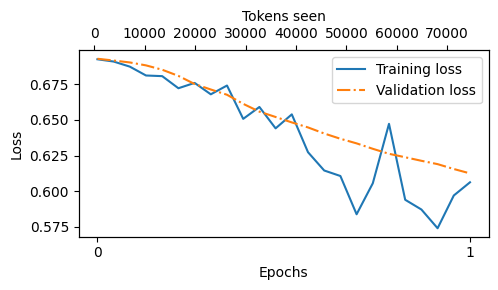

In [58]:
epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    # label="loss"
)

- As we can see above, the loss continues to improve, which is a good sign.
- Based on the downward slope, one might be tempted to train the model a bit further (and readers are encouraged to try this), but note that DPO is prone to collapse, where the model may start generating nonsensical responses.

- Next, let's take a look at the reward margins.

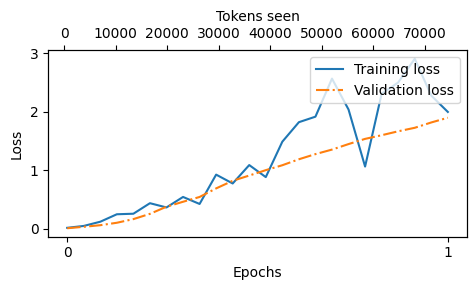

In [59]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    # label="reward margins"
)

- As we can see, and as it's desired, the reward margins improve, this mirrors the loss curve and is a good sign.
- Note that DPO losses and reward margins are valuable metrics to track during training; however, they don't tell the whole story.

- Lastly, and most importly, we have to conduct a qualitative check of the responses.
- Here, we will look at the response.

In [60]:
torch.manual_seed(123)

for entry in val_data[:3]:
    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text=token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text=token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n----------------------------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Reference model response:
>> The meal is cooked every day by the chef.

Policy model response:
>> The meal was prepared by the chef.

----------------------------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Reference model response:
>> Dance is a verb.

Policy model response:
>> The input 'Dance' could be classified as a verb.

----------------------------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the reque

In [61]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a bullet.

Policy model response:
>> The car was as fast as an elephant.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Policy model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.

-------------------------------------

Below is an instruction that describes a task. Write a response 